# Ginkgo clustering environment

## Setup

In [1]:
%matplotlib inline

import copy
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from tqdm import trange

from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import BaseCallback

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DEnv, GinkgoLikelihoodShuffledEnv, GinkgoEvaluator


/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/johannbrehmer/anaconda3/env

In [2]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [ ]:
set_output(True)
env = GinkgoLikelihoodEnv(n_max=6, illegal_reward=0., min_reward=None)
state = env.reset()
env.render()

In [4]:
for i, (children, p, log_likelihood_split, delta) in enumerate(zip(
    env.jet['tree'], env.jet['content'], env.jet['logLH'], env.jet['deltas']
)):
    if children[0] < 0 and children[1] < 0:
        print(f"{i}: {p}. Leaf.")
    else:
        print(f"{i}: {p}. {i} -> ({children[0]}, {children[1]}) with log p = {log_likelihood_split}, delta = {delta}")

0: [407.92156109 230.94010768 230.94010768 230.94010768]. 0 -> (1, 6) with log p = -17.403776168823242, delta = 6400.0
1: [86.21212618 59.47897381 24.05681927 54.12220646]. 1 -> (2, 3) with log p = -9.674421310424805, delta = 386.83843994140625
2: [27.43745657 23.8328098   5.86147131 11.77914382]. Leaf.
3: [58.77466961 35.64616401 18.19534796 42.34306264]. 3 -> (4, 5) with log p = -4.240090370178223, delta = 59.80708694458008
4: [13.31446365  8.02012186  3.82370331  9.30602139]. Leaf.
5: [45.46020595 27.62604215 14.37164465 33.03704125]. Leaf.
6: [321.70943491 171.46113387 206.8832884  176.81790122]. 6 -> (7, 8) with log p = -3.33705735206604, delta = 32.7749137878418
7: [119.06990111  62.54305702  76.09229628  66.84844151]. Leaf.
8: [202.63954719 108.91808398 130.79100074 109.96946707]. Leaf.


In [5]:
# Merge two particles
action = 0, 1

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


17:22 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (0, 1)
17:22 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (0, 1): ti = 0.0, tj = 0.0, t_cut = 16.0, lam = 1.5 -> log likelihood = -5.247735977172852
17:22 ginkgo_rl.envs.ginkg DEBUG   Merging particles 0 and 1. New state has 4 particles.
17:22 ginkgo_rl.envs.ginkg INFO    4 particles:
17:22 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  0.4,   0.3,   0.1,   0.2)
17:22 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.5,   0.3,   0.1,   0.3)
17:22 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  1.2,   0.6,   0.8,   0.7)
17:22 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  2.0,   1.1,   1.3,   1.1)


Reward: -5.247735977172852
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 0, 'j': 1}


In [4]:
env.close()

## Env checker

In [5]:
set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")

check_env(env)

for i in range(env.n_max):
    assert i == env.inverse_permutation[env.permutation[i]] == env.permutation[env.inverse_permutation[i]]
    
env.close()

/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "


## Evaluation routine

In [7]:
set_output(False)
evaluator = GinkgoEvaluator()


## True log likelihoods

In [8]:
set_output(False)
evaluator.eval_true("Truth")


## Maximum log likelihood (through Trellis)

In [9]:
set_output(False)
evaluator.eval_exact_trellis("ML (Trellis)")


## Random clusterings

In [10]:
set_output(False)
evaluator.eval_random("Random", env_name="GinkgoLikelihood-v0")


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )
/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


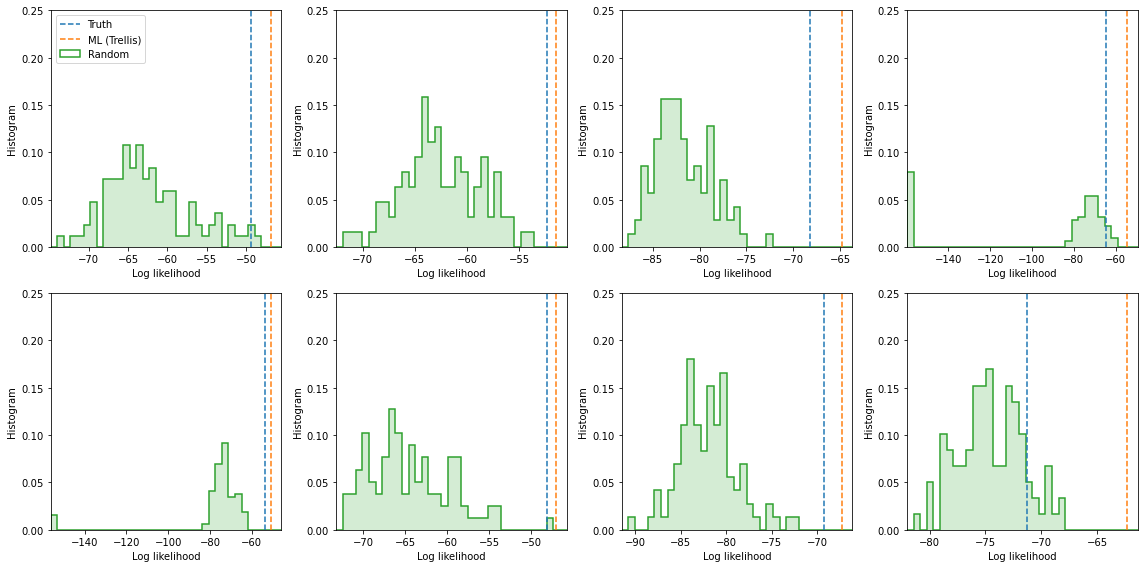

In [11]:
_ = evaluator.plot_log_likelihoods()

## RL preparation

In [12]:
log_dirs = []
models = {}
env_names = {}

def train(algorithm, algo_class, policy_class, env_name="GinkgoLikelihoodShuffled1D-v0", n_steps=20000, eval_freq=1000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()


## PPO

In [ ]:
train("ppo", PPO2, MlpPolicy, env_name="GinkgoLikelihoodShuffled-v0")

/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


## DQN

In [ ]:
train("dqn", DQN, DQNMlpPolicy)

## Training progress

In [ ]:
results_plotter.plot_results(log_dirs[0:2], 1e5, results_plotter.X_TIMESTEPS, "Ginkgo")


## Evaluate

In [ ]:
evaluator.eval("PPO", models["ppo"], "GinkgoLikelihoodShuffled-v0")

In [ ]:
evaluator.eval("DQN", models["dqn"], "GinkgoLikelihoodShuffled1D-v0")

In [ ]:
_ = evaluator.plot_log_likelihoods()